# Clustering with DBSCAN

In [1]:
# Modify sys.path to allow imports of own modules
import os
import sys

BASE_DIR = os.path.join(os.path.abspath(""), "..")
sys.path.insert(0, BASE_DIR)

from clustering import dbscan
from data.datasource import load_X_y

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from IPython.display import display
from time import time

## Preparing dataset

In [3]:
# Load dataset
X, y, df = load_X_y(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"), sample_size=500)

np.random.seed(42)

n_samples, n_dims = X.shape

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


## Choosing parameters

There is a heuristic to set `min_pts` equal to twice the number of input dimensions, i. e., `2 * n_dims`. For `eps` we take a look at the sorted distance to the k nearest neighbors with k = `min_pts` and search for the knee/elbow of the function.


In [4]:
min_pts = 2 * n_dims

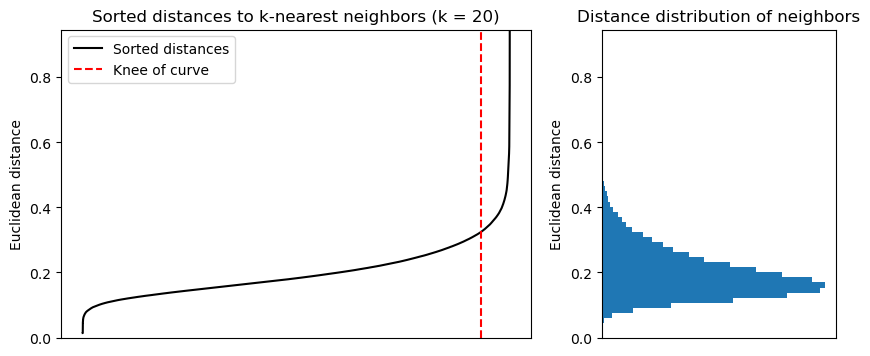

In [5]:
# Compute distances to k-nearest neighbors using scikit-learn
nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X) # type: NearestNeighbors
distances, _ = nbrs.kneighbors(X)

# Sort in ascending order
distances = np.sort(distances.flatten())
# Remove zeros
distances = distances[distances > 0]

# Determine position where the sorted distance curve has the largest "curvature" to detect knee
curvature = np.abs(distances - np.linspace(0, distances[-1], len(distances)))
best_distance_index = np.argmax(curvature)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
for i in range(2):
    axs[i].set_ylabel("Euclidean distance")
    axs[i].set_ylim((0, distances[-1]))
    axs[i].axes.get_xaxis().set_visible(False)

axs[0].plot(distances, label="Sorted distances", c="black")
axs[0].axvline(best_distance_index, color="red", linestyle="--", label="Knee of curve")
axs[0].legend()
axs[0].set_title(f"Sorted distances to k-nearest neighbors (k = {min_pts})")

axs[1].hist(distances, bins=60, orientation="horizontal")
axs[1].set_title(f"Distance distribution of neighbors")
pass

In [6]:
# Set epsilon parameter according to the detected knee
eps = distances[best_distance_index]
eps

0.3243739010428709

## Run DBSCAN clustering

In [7]:
# Run algorithm with chosen parameters and measure runtime
start_time = time()
_, cluster_indices = dbscan.dbscan(X, epsilon=eps, min_points=2 * n_dims)
duration = time() - start_time

print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_dims}\n")
print(f"Runtime of algorithm: {duration*1000:.1f} ms\n")

cluster_stats = pd.Series(cluster_indices).value_counts()
print(f"Number of clusters: {np.sum(cluster_stats.index != -1)}")
print("Number of points in clusters:")
for cluster_index in sorted(cluster_stats.index):
    if cluster_index == -1:
        print(" - Outliers:  ", cluster_stats[cluster_index])
    else:
        print(f" - Cluster {cluster_index}: ", cluster_stats[cluster_index])

Number of samples: 12500
Number of features: 10

Runtime of algorithm: 5998.2 ms

Number of clusters: 3
Number of points in clusters:
 - Outliers:   360
 - Cluster 0:  11691
 - Cluster 1:  16
 - Cluster 2:  433


## Evaluate results

<Axes: >

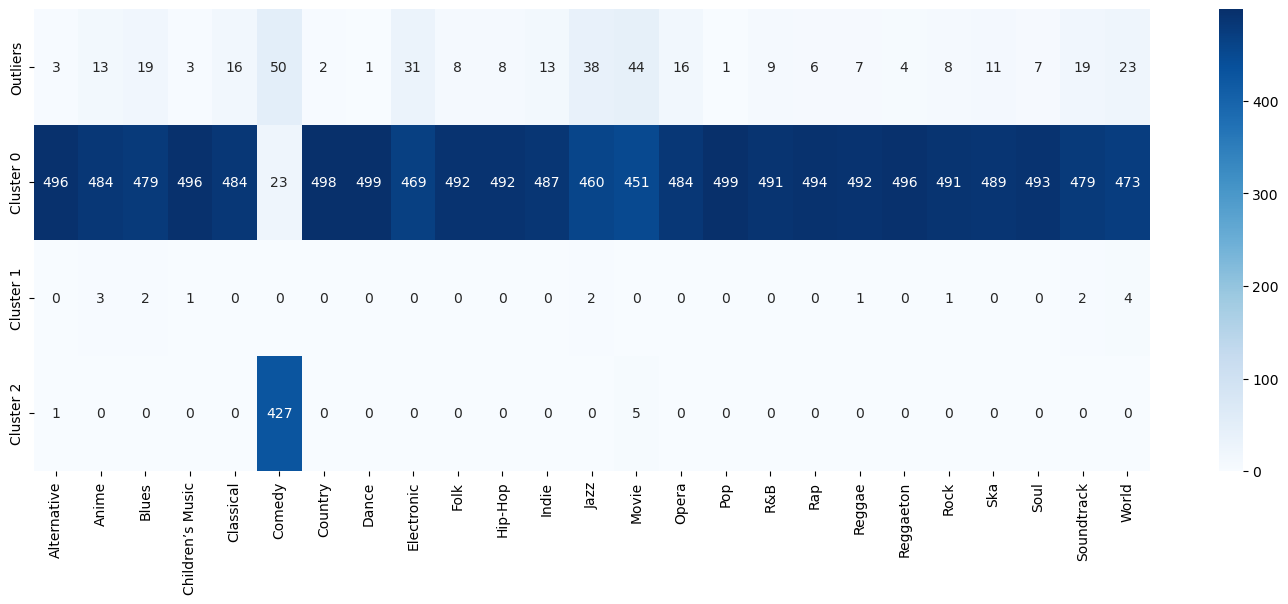

In [8]:
n_genres = df.genre.nunique()
n_clusters = cluster_indices.max() + 1

confusion_matrix = np.zeros((n_clusters + 1, n_genres))

genres = list(df.genre.unique())

for i in range(-1, n_clusters):
    for genre, hits in df[cluster_indices == i].genre.value_counts().items():
        confusion_matrix[i+1, genres.index(genre)] = hits

confusion_matrix = pd.DataFrame(confusion_matrix, columns=genres, index=("Outliers" if i == -1 else f"Cluster {i}" for i in range(-1, n_clusters)))

fig, ax = plt.subplots(figsize=(18, 6))
sn.heatmap(confusion_matrix, annot=True, ax=ax, fmt=".0f", cmap="Blues")

In [9]:
df[cluster_indices == 1]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_numeric
28190,Anime,Kevin Penkin,OhKami,574otzRwXGWmLemR5fYAWY,35,0.923,0.649,198693,0.753,0.794,F,0.1080,-8.311,Major,0.0296,140.004,4/4,0.753,1
29223,Anime,Aun J-Classic Orchestra,My Neighbor Totoro (My Neighbor Totoro),4r1PcJciNMlwyk6GXKxoiY,30,0.818,0.697,251600,0.716,0.839,D,0.0933,-6.200,Minor,0.0335,126.015,4/4,0.737,1
28329,Anime,Nobuo Uematsu,Roses of May,35sb7fb28uy8r3GX4btTrb,35,0.887,0.699,154093,0.621,0.891,F,0.2080,-14.447,Major,0.0512,97.503,3/4,0.867,1
45879,Blues,Booker T. & the M.G.'s,Green Onions - 45 Version,6KKcey1w86oP0qxN8frbfD,57,0.811,0.788,167385,0.380,0.906,A#,0.1020,-15.179,Major,0.0346,138.205,4/4,0.892,2
47818,Blues,Junior Kimbrough,I Gotta Try You Girl,14u5dfxMsAxW2sqEUSR8to,35,0.720,0.650,326867,0.538,0.784,C#,0.0851,-10.123,Major,0.0327,165.536,4/4,0.679,2
103033,Children’s Music,Caribou,Bees,2XqMEvXJVK8FlcjeNYyplk,48,0.800,0.714,323667,0.590,0.901,A,0.1110,-12.821,Major,0.0304,130.710,4/4,0.784,3
181418,Jazz,Chuck Loeb,"North, South, East And Wes",6xcsBZ4OsUrEEctFEhiUWR,30,0.830,0.856,335067,0.676,0.818,G,0.1010,-8.494,Major,0.0421,120.020,4/4,0.786,12
148108,Jazz,Boney James,Hold On Tight,5qsm0eGh4vPXOOEKNrH6cX,37,0.622,0.537,304653,0.521,0.859,D#,0.1200,-11.084,Minor,0.0432,135.589,4/4,0.781,12
133555,Reggae,Bunny Wailer,Armagideon (Armagedon),7BxBzBOsfhdBEX7g2FFP06,31,0.738,0.695,405493,0.477,0.774,A,0.0740,-12.181,Minor,0.1360,149.563,4/4,0.783,18
153214,Rock,Current Joys,Blondie,4UkCtBCYh6VMsucGMQZyh9,53,0.622,0.776,194733,0.625,0.896,F#,0.0860,-12.561,Major,0.0396,122.072,4/4,0.865,20


In [10]:
df[(cluster_indices == -1) & df.genre.isin(("Pop", "Dance", "Rock"))]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_numeric
21919,Dance,Hayley Kiyoko,xx,1v0uMj6rNBAA4wsq6rLkqL,48,0.289000,0.617,51600,0.485,0.862000,A,0.2940,-8.568,Minor,0.0795,186.006,4/4,0.3000,7
151553,Pop,Jorja Smith,Teenage Fantasy,0fIFjeeLJjIBliWUCsxyMF,68,0.470000,0.583,226906,0.677,0.193000,E,0.4300,-10.210,Minor,0.4390,176.119,4/4,0.4950,15
223631,Rock,Current Joys,New Flesh,6TEiFwaiHERpdfG6WnGed1,58,0.887000,0.621,167987,0.594,0.498000,A,0.0917,-16.066,Major,0.0384,165.863,4/4,0.6980,20
153244,Rock,Caifanes,La Negra Tomasa - Bilongo - Versión Tropical,6cVHu0HmKo4oEOSOqooTa3,62,0.234000,0.530,472400,0.683,0.311000,D,0.2740,-7.130,Major,0.0313,174.441,4/4,0.6940,20
166922,Rock,Queen,Love Of My Life - Live at Rock in Rio Festival,0GN3KwXNPI6wNmLlbSoVzi,63,0.807000,0.228,268703,0.563,0.000009,D,0.8090,-11.962,Major,0.0953,111.700,5/4,0.0713,20
222112,Rock,Tom Petty,Runnin' Down A Dream,6mNqjI8t57Iwaz21IS7cl0,57,0.000596,0.471,261813,0.956,0.620000,A,0.6240,-6.371,Major,0.0403,169.798,4/4,0.7150,20
225296,Rock,BOYO,Mantra,0ibhQJyObOOn2va4LjjpDC,55,0.333000,0.703,144000,0.490,0.828000,C,0.4240,-7.430,Major,0.0304,100.028,4/4,0.7080,20
225463,Rock,Lucy Dacus,...Familiar Place,0lp0bQqzyLmNNHHFYRaaJf,62,0.012800,0.214,175778,0.148,0.058000,G,0.1130,-17.775,Major,0.0370,46.591,4/4,0.0277,20
154839,Rock,Jimi Hendrix,One Rainy Wish,5Zyv0v4rPcrXjkaeImuodv,51,0.294000,0.316,221827,0.756,0.429000,G#,0.3510,-6.315,Major,0.1000,165.963,4/4,0.3320,20
225342,Rock,The National,The System Only Dreams in Total Darkness,1HAzsv7VCvbgqrpenTRWj1,63,0.156000,0.596,236747,0.912,0.794000,C,0.5840,-6.740,Minor,0.2110,110.013,4/4,0.3710,20


## Experimenting with DBSCAN parameters

In [11]:
import itertools
from tqdm import tqdm

min_pts_search_space = [5, min_pts, 50]
eps_search_space = np.linspace(.2, .35, 20)

results = np.zeros((len(min_pts_search_space), len(eps_search_space), 3))

search_space = list(itertools.product(enumerate(min_pts_search_space), enumerate(eps_search_space)))
for (i, candidate_min_pts), (j, candidate_eps) in tqdm(search_space, ncols=100):
    _, cluster_indices = dbscan.dbscan(X, epsilon=candidate_eps, min_points=candidate_min_pts)
    n_clusters = cluster_indices.max() + 1
    n_outliers = np.sum(cluster_indices == -1)

    # Store number of clusters and outliers
    results[i, j, :2] = (n_clusters, n_outliers)

    # Compute deviation from expected cluster sizes
    cluster_sizes = pd.Series(cluster_indices[cluster_indices != -1]).value_counts()
    target_cluster_size = n_samples / df.genre.nunique()
    results[i, j, 2] = np.sqrt(np.sum((cluster_sizes - target_cluster_size)**2))


100%|███████████████████████████████████████████████████████████████| 60/60 [04:00<00:00,  4.01s/it]


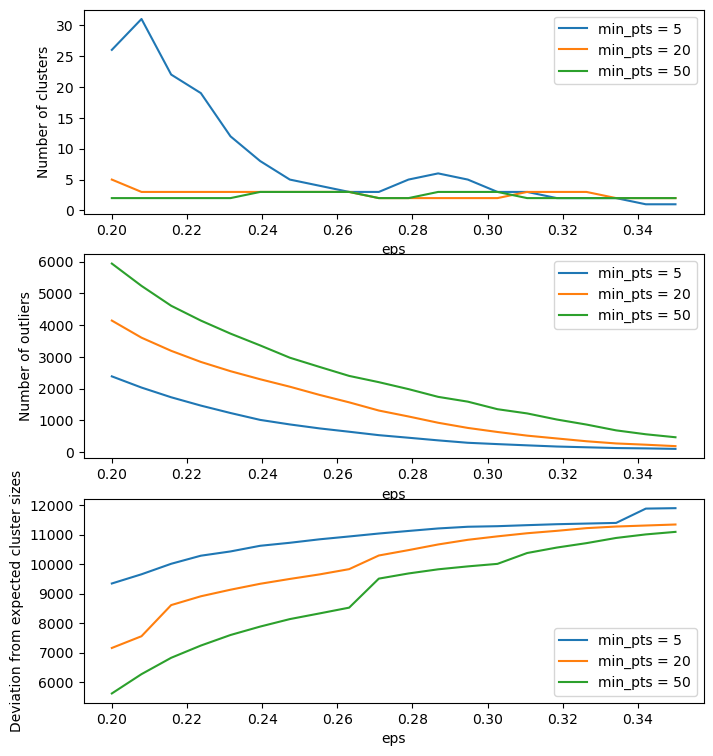

In [13]:
fix, axs = plt.subplots(3, 1, figsize=(8, 9))

names = [
    "Number of clusters",
    "Number of outliers",
    "Deviation from expected cluster sizes",
]

for j, name in enumerate(names):
    ax = axs[j]
    for i, min_pts in enumerate(min_pts_search_space):
        ax.set_ylabel(name)
        ax.plot(eps_search_space, results[i, :, j], label=f"min_pts = {min_pts}")
    
    ax.legend()
    ax.set_xlabel("eps")